In [3]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback

from timm.models.layers import patch_embed 
from timm.models import vision_transformer
from timm.models.vision_transformer import _create_vision_transformer

from PIL import Image
import requests

import torch
from torch import nn
import torchvision.transforms as T

import matplotlib.pyplot as plt
from timm.models.helpers import build_model_with_cfg

In [2]:
from itertools import repeat
import collections.abc

In [3]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [4]:
def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple


def make_divisible(v, divisor=8, min_value=None, round_limit=.9):
    min_value = min_value or divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < round_limit * v:
        new_v += divisor
    return new_v

In [5]:
to_2tuple(16)

(16, 16)

In [16]:
H = 224
W= 224

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

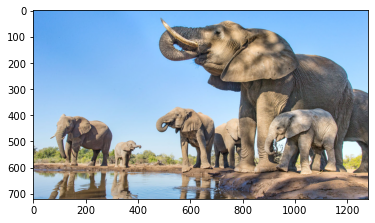

In [13]:
url1 = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://cms.qz.com/wp-content/uploads/2019/12/airplane-e1575485422322.jpg?quality=75&strip=all&w=1200&h=900&crop=1'
url3 = 'https://autocar.com.ph/wp-content/uploads/2018/01/Ayrton_Senna_-_Mclaren_MP4-8_during_practice_for_the_1993_British_Grand_Prix_32873580103.jpg'
url4 = 'https://static.scientificamerican.com/sciam/cache/file/ACF0A7DC-14E3-4263-93F438F6DA8CE98A_source.jpg?w=590&h=800&896FA922-DF63-4289-86E2E0A5A8D76BE1'
url5 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
url6 = 'https://southernboating.com/wp-content/uploads/2019/11/New-running-530-0832-1024x600.jpg'
IMG_URL = url5
im = Image.open(requests.get(IMG_URL, stream=True).raw)
plt.plot()
plt.imshow(im)

In [17]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 224, 224])


In [39]:
vit = vision_transformer._create_vision_transformer('vit_base_patch16_224',pretrained=True)

In [40]:
pred = vit(img)

Input shape: torch.Size([1, 3, 224, 224])
Shape before the conv torch.Size([1, 3, 224, 224])
Shape after the conv torch.Size([1, 768, 14, 14])
Patches shape: 1
Patches after Token shape: torch.Size([1, 196, 768])


RuntimeError: The size of tensor a (196) must match the size of tensor b (197) at non-singleton dimension 1

In [34]:
amap = pred[1][:,:,:196,:196].reshape(1,12,14,14,14,14)#.permute(0,1,5,3,2,4)

In [35]:
attmap = amap[0][0]
for i in range(1,12):
    attmap = attmap + attmap[0][i]

In [36]:
attmap.shape

torch.Size([14, 14, 14, 14])

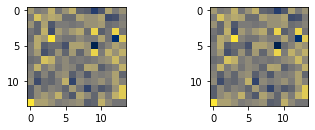

In [37]:
plt.subplot(221)
plt.imshow(attmap[5][5].detach().numpy(),cmap='cividis', interpolation='nearest')
plt.subplot(222)
plt.imshow(attmap[0][0].detach().numpy(),cmap='cividis', interpolation='nearest')

In [55]:
pred.head = nn.Linear(768, 10)

In [56]:
for name, p in vit.named_parameters():
    if name == 'head.weight' or name == 'head.bias':
        print(name)
        p.requires_grad = True
    else:
        p.requires_grad = True

head.weight
head.bias


In [57]:
def Accuracy(preds,target): 

    _, pred = torch.max(preds, 1)

    return (pred == target).float().mean()

In [58]:
path = untar_data(URLs.IMAGENETTE_320)

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path/'train',bs=10) 

In [59]:
loss = nn.CrossEntropyLoss()

In [60]:
learner = Learner(dloader, vit, loss_func=loss, metrics=[Accuracy])

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=3.630780702224001e-05)

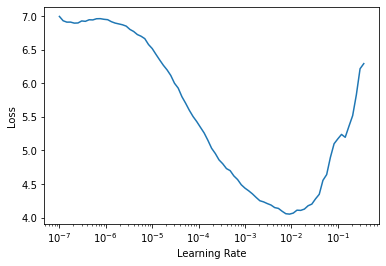

In [61]:
learner.lr_find()

In [63]:
learner.fit(10, 0.001)

epoch,train_loss,valid_loss,Accuracy,time
0,2.340433,2.324043,0.094031,02:03
1,2.322677,2.308506,0.112520,02:03
2,2.329633,2.287821,0.125198,02:04
3,2.264142,2.256179,0.136820,02:03
4,2.247782,2.254600,0.162705,02:04


KeyboardInterrupt: 

In [6]:
class _Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        #print("attn shape:", attn.shape)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        #print("attn shape:", x.shape)
        x = self.proj(x)
        #print("attn shape:", x.shape)
        x = self.proj_drop(x)
        #print("x shape:", x.shape)
        return x, attn

vision_transformer.Attention = _Attention

In [7]:
class _Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = _Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        if len(x) == 2:
                x = x[0]
        x, sattn = self.attn(self.norm1(x))
        x = x + self.drop_path(x)
        #print("x shape:", x.shape)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, sattn
    
vision_transformer.Block = _Block

In [8]:
def _forward(self, x):
        print("Input shape:", x.shape)
        x, sattn = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x, sattn

vision_transformer.VisionTransformer.forward = _forward

In [38]:
def _forward_features(self, x):
    x = ptemb(x)
    print("Patches shape:", len(x))#.shape)
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    #if self.dist_token is None:
    #    x = torch.cat((cls_token, x), dim=1)
    #else:
    #    x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
    print("Patches after Token shape:",x.shape)
    x = self.pos_drop(x + self.pos_embed)
    x, sattn = self.blocks(x)
    x = self.norm(x)
    if self.dist_token is None:
        return self.pre_logits(x[:, 0]), sattn
    else:
        return x[:, 0], x[:, 1], sattn
vision_transformer.VisionTransformer.forward_features = _forward_features

In [10]:
class _PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        #print("Shape before the conv", x.shape)
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        #print("Shape after the conv", x.shape)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x
patch_embed.PatchEmbed = _PatchEmbed
ptemb = _PatchEmbed()

In [12]:
a = torch.rand([5,8,16,16,16,16])
b = torch.rand([5,16,16,16,16]).unsqueeze(1)
c = a*b
c.shape

torch.Size([5, 8, 16, 16, 16, 16])

In [10]:
b.unsqueeze(1).shape

torch.Size([5, 1, 16, 16, 16, 16])